#### The networkx library is used to visualize the graph and find the shortest path.    
Based on publication: https://habr.com/ru/post/125898/

In [1]:
# !pip install plotly
# !pip install networkx

In [2]:
from stl import mesh
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

In [3]:
def plot_mesh(
    your_mesh, 
    size_x=10, 
    size_y=10, 
    dpi=80, 
    filename = None
    ):
    # Create a new plot
    figure = plt.figure(figsize=(size_x, size_y), dpi=dpi)
    #axes = mplot3d.Axes3D(figure, auto_add_to_figure=False)
    axes = mplot3d.Axes3D(figure)
    axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors, edgecolor="black"))
    figure.add_axes(axes)
    # Auto scale to the mesh size
    scale = your_mesh.points.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    # Show or save the plot
    if filename is None:
        plt.show()
    else:
        #matplotlib.use('Agg')
        plt.savefig(filename)

In [4]:
def create_voxel(side, tx, ty, tz):
    vertices = np.array([
       [tx + 0,     ty + 0,      tz + 0],
       [tx + side,  ty + 0,      tz + 0],
       [tx + side,  ty + side,   tz + 0],
       [tx + 0,     ty + side,   tz + 0],
       [tx + 0,     ty + 0,      tz + side],
       [tx + side,  ty + 0,      tz + side -0.5],
       [tx + side,  ty + side,   tz + side],
       [tx + 0,     ty + side,   tz + side]
    ])

    faces = np.array([
        [3, 2, 1],
        [3, 1, 0],
        [0, 1, 5],#
        [5, 4, 0],
        [7, 3, 0],
        [0, 4, 7],#
        [1, 2, 6],#
        [6, 5, 1],
        [2, 3, 6],#
        [3, 7, 6],#
        [4, 5, 6],#
        [6, 7, 4]
     ])
    voxel = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            voxel.vectors[i][j] = vertices[f[j],:]
    return voxel

#### Create numpy-stl cube with side = 1
We made z distortion in vertice (1,0,0.5), to demonstrate shortest path algorithm.   
Let's find shortest path from vertice: (0,0,1)   
To vertice: (1,0,0)   
As we see, the shortest path should be:   
(0,0,1)   
(1,0,0.5)   
(1,0,0)   

In [5]:
voxel = create_voxel(1, 0, 0, 0)

/tmp/ipykernel_39838/3261262402.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


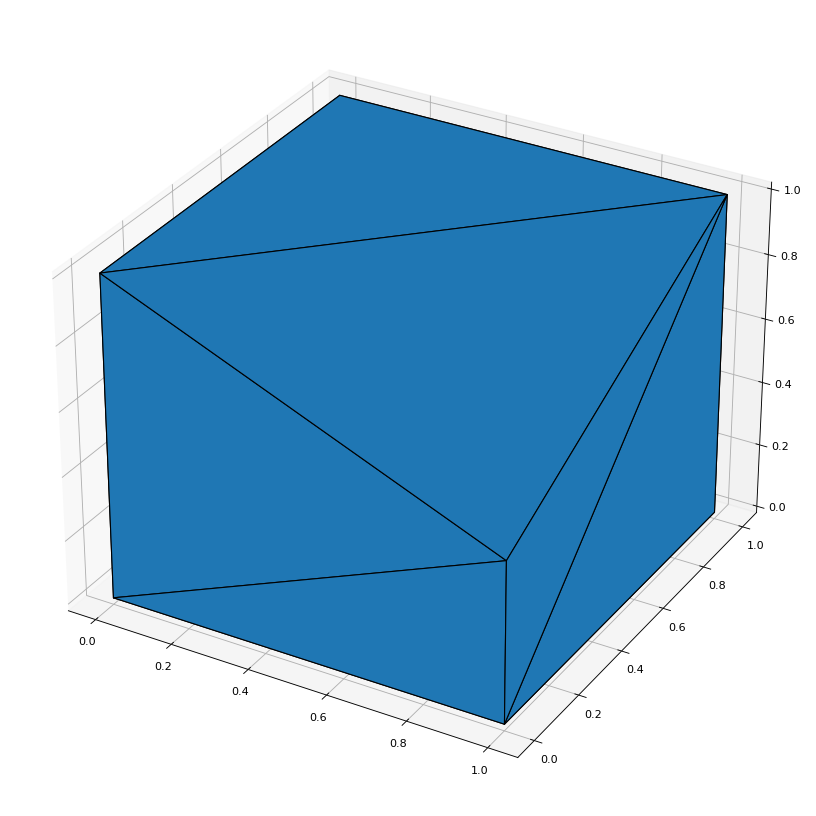

In [6]:
plot_mesh(voxel)

#### Cube have 12 triangle faces. Each vector is one face

In [7]:
len(voxel.vectors)

12

#### Each face is described by three vertices 

In [8]:
len(voxel.vectors[0]), voxel.vectors[0]

(3,
 array([[0., 1., 0.],
        [1., 1., 0.],
        [1., 0., 0.]], dtype=float32))

#### Each vertice described by coordinates in 3-dimensional space

In [9]:
len(voxel.vectors[0][0]), voxel.vectors[0][0]

(3, array([0., 1., 0.], dtype=float32))

#### Get unique vertices

In [10]:
vertices = set()
for face in voxel.vectors:
    for vertice in face:
        vertices.add(tuple([x for x in vertice]))
len(vertices), vertices

(8,
 {(0.0, 0.0, 0.0),
  (0.0, 0.0, 1.0),
  (0.0, 1.0, 0.0),
  (0.0, 1.0, 1.0),
  (1.0, 0.0, 0.0),
  (1.0, 0.0, 0.5),
  (1.0, 1.0, 0.0),
  (1.0, 1.0, 1.0)})

#### Set id of each vertice

In [11]:
vertices_named = dict()
i = 0
for vertice in vertices:
    vertices_named[vertice] = i
    i += 1
vertices_named

{(1.0, 1.0, 0.0): 0,
 (0.0, 1.0, 0.0): 1,
 (0.0, 0.0, 0.0): 2,
 (1.0, 0.0, 0.0): 3,
 (1.0, 0.0, 0.5): 4,
 (0.0, 0.0, 1.0): 5,
 (1.0, 1.0, 1.0): 6,
 (0.0, 1.0, 1.0): 7}

#### Discribe relations between vertices
Every triangle face have 3 relations   
We could describe each relation as tuple: (id0, id1, distance between vertices)

In [12]:
def vertice_by_id(vertices_named, vertice_id):
    for vertice, current_id in vertices_named.items():
        if current_id == vertice_id:
            return vertice

In [13]:
def distance_between_vertices(vertices_named, ida, idb):
    vector1 = np.array(list(vertice_by_id(vertices_named, ida)))
    vector2 = np.array(list(vertice_by_id(vertices_named, idb)))
    return np.linalg.norm(vector1-vector2)

In [14]:
relations = list()
for face in voxel.vectors:    
    ids = []
    for vertice in face:
        vertice_id = vertices_named[tuple(vertice)]
        ids.append(vertice_id)
    relations.append((ids[0], ids[1], distance_between_vertices(vertices_named, ids[0], ids[1])))
    relations.append((ids[1], ids[2], distance_between_vertices(vertices_named, ids[1], ids[2])))
    relations.append((ids[0], ids[2], distance_between_vertices(vertices_named, ids[0], ids[2])))
relations

[(1, 0, 1.0),
 (0, 3, 1.0),
 (1, 3, 1.4142135),
 (1, 3, 1.4142135),
 (3, 2, 1.0),
 (1, 2, 1.0),
 (2, 3, 1.0),
 (3, 4, 0.5),
 (2, 4, 1.118034),
 (4, 5, 1.118034),
 (5, 2, 1.0),
 (4, 2, 1.118034),
 (7, 1, 1.0),
 (1, 2, 1.0),
 (7, 2, 1.4142135),
 (2, 5, 1.0),
 (5, 7, 1.0),
 (2, 7, 1.4142135),
 (3, 0, 1.0),
 (0, 6, 1.0),
 (3, 6, 1.4142135),
 (6, 4, 1.118034),
 (4, 3, 0.5),
 (6, 3, 1.4142135),
 (0, 1, 1.0),
 (1, 6, 1.4142135),
 (0, 6, 1.0),
 (1, 7, 1.0),
 (7, 6, 1.0),
 (1, 6, 1.4142135),
 (5, 4, 1.118034),
 (4, 6, 1.118034),
 (5, 6, 1.4142135),
 (6, 7, 1.0),
 (7, 5, 1.0),
 (6, 5, 1.4142135)]

#### Discribe relations as graph

(EdgeView([(1, 0), (1, 3), (1, 2), (1, 7), (1, 6), (0, 3), (0, 6), (3, 2), (3, 4), (3, 6), (2, 4), (2, 5), (2, 7), (4, 5), (4, 6), (5, 7), (5, 6), (7, 6)]),
 NodeView((1, 0, 3, 2, 4, 5, 7, 6)))

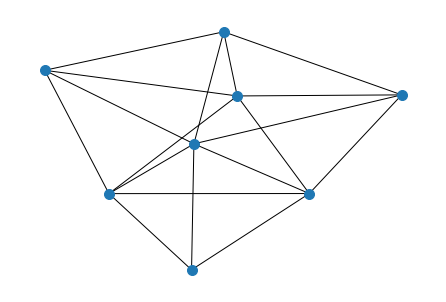

In [15]:
G=nx.Graph()
G.add_weighted_edges_from(relations)
nx.draw(G, node_size = 100)
G.edges, G.nodes

#### define id of test vertices and calculate the shortest path

In [16]:
test_vertices = [(0,0,1), (1,0,0.5), (1,0,0)]
test_ids = [vertices_named[tuple(vertice)]for vertice in test_vertices]

#### Shortest path 5 to 3

In [17]:
print('== Shortest path ==\nFrom:', test_ids[0], test_vertices[0], '\nTo:', test_ids[2], test_vertices[2])
path = nx.dijkstra_path(G,test_ids[0],test_ids[2])
print('ids path:', path)
print('vertices path:', [vertice_by_id(vertices_named, p) for p in path])

== Shortest path ==
From: 5 (0, 0, 1) 
To: 3 (1, 0, 0)
ids path: [5, 4, 3]
vertices path: [(0.0, 0.0, 1.0), (1.0, 0.0, 0.5), (1.0, 0.0, 0.0)]
